In [2]:
# import sys
# import time
# import os
# sys.path.append('..')
# sys.path.append('../lib-python')
# print ("LD: " + os.getenv("LD_LIBRARY_PATH"))
# import numpy as np
# from netCDF4 import Dataset
# import collections
# #import interpolators
# import optimal_estimation_core_pure_python as oec
# #import optimal_estimation as oe
# import cloud_core
# #import optimal_estimation as oe
# sys.path.append('..')
# #import lut2func
# #import lut2jacobian_lut
# print ("bla")

In [3]:
%matplotlib inline
import sys
import time
sys.path.append('..')
from netCDF4 import Dataset
import pylab as pl
import numpy as np
import scipy.interpolate as interp
import datetime

print ("blubb")

import cloud_core 
reload(cloud_core)
cc=cloud_core.cloud_core('../luts/cloud_core_meris.nc4')

print ("bla")

def cosd(inn):
    return np.cos(inn*np.pi/180.)
def sind(inn):
    return np.sin(inn*np.pi/180.)
def acosd(inn):
    return np.arccos(inn)*180./np.pi
def asind(inn):
    return np.arcsin(inn)*180./np.pi

def azi2azid(sa,va):
    return acosd(cosd(sa)*cosd(va)+sind(sa)*sind(va))

def height2press(hh):
        return 1013.*(1.-(hh*0.0065/288.15))**5.2555


#This is very MERIS specific ....
#meris spectral calibration data
with Dataset('stray_coeff_potenz4.nc') as nc:
    meris_lam=nc.variables['LAMBDA'][:]
    meris_str=nc.variables['STRAY'][:]

blubb
bla


In [4]:
#stride=(3,3)
#stride=(2,2)
stride=(10,10)
print ("hier 2")
with Dataset('MER_RR__1PRACR20070601_090923_000026432058_00351_27459_0000.h5','r') as h5:
    h5g=h5.groups['bands']
    rad={var:h5g.variables[var][:,:]*1. for var in h5g.variables}
    for kkk in h5g.variables:
        if 'radiance' in kkk:
            rad['norm_'+kkk]=rad[kkk]*h5g.variables[kkk].scaling_factor
            rad['norm_'+kkk]/=h5g.variables[kkk].solar_flux
        
    for kkk in rad:
        #print kkk
        rad[kkk]=rad[kkk][::stride[0],::stride[1]].astype(np.float)
        
    h5g=h5.groups['tie_point_grids']
    tie={var:h5g.variables[var][::,::].astype(np.float) for var in h5g.variables}

    # quick and dirty regridding of tiepoints
    new_x,new_y=rad['norm_radiance_1'].shape
    old_x,old_y=tie['ozone'].shape
    old_xx=np.linspace(0.,new_x,old_x)
    old_yy=np.linspace(0.,new_y,old_y)
    new_xx=np.arange(new_x)
    new_yy=np.arange(new_y)
    for kkk in tie:
        if 'lon' not in kkk:
            tie[kkk]=interp.RectBivariateSpline(old_xx, old_yy, tie[kkk], kx=1, ky=1)(new_xx, new_yy)
            #print kkk

#longitude regrid
re=np.sin(tie['longitude']*np.pi/180.)
im=np.cos(tie['longitude']*np.pi/180.)
re_out=interp.RectBivariateSpline(old_xx, old_yy, re, kx=1, ky=1)(new_xx, new_yy)
im_out=interp.RectBivariateSpline(old_xx, old_yy, im, kx=1, ky=1)(new_xx, new_yy)
tie['lon']=np.arctan2(re_out,im_out)*180./np.pi
#azimuth difference
tie['ada']=azi2azid(tie['sun_azimuth'],tie['view_azimuth'])

#surface pressure
tie['prs']=height2press(tie['dem_alt']).clip(0,1013.)# speciffic meris 



rad['lam11']  = meris_lam[rad['detector_index'].astype(np.int)]
rad['stray']  = meris_str[rad['detector_index'].astype(np.int)] * rad['norm_radiance_10']
rad['norm_radiance_11'] +=  rad['stray']

#sub-setting
anf=4000
nde=6000
anf=9000
nde=12500
anf=000
nde=-1

print ("hier 3")
for fff in (rad,tie):
    for kkk in fff:
        fff[kkk]=fff[kkk][anf//stride[0]:nde//stride[0],:]

hier 2
hier 3


In [5]:
#quick and dirty surface albedo
lat_idx=np.round((90.-tie['latitude'])*20).astype(np.int).clip(0,3599)
lon_idx=np.round((180+tie['lon'])*20).astype(np.int).clip(0,7199)
# day of year of used MERIS data
doy=datetime.date(2007,6,1).timetuple().tm_yday

with Dataset('../luts/ws_alb_10_2005.nc') as nc:
    #get closest day of year
    doy_idx=np.abs(nc.variables['time'][:]-doy).argmin()
    alb = nc.variables['albedo'][doy_idx,:,:]
    #get closest albedo
    #nearest neighbour
    rad['alb10']= alb[lat_idx,lon_idx].clip(0,1.)

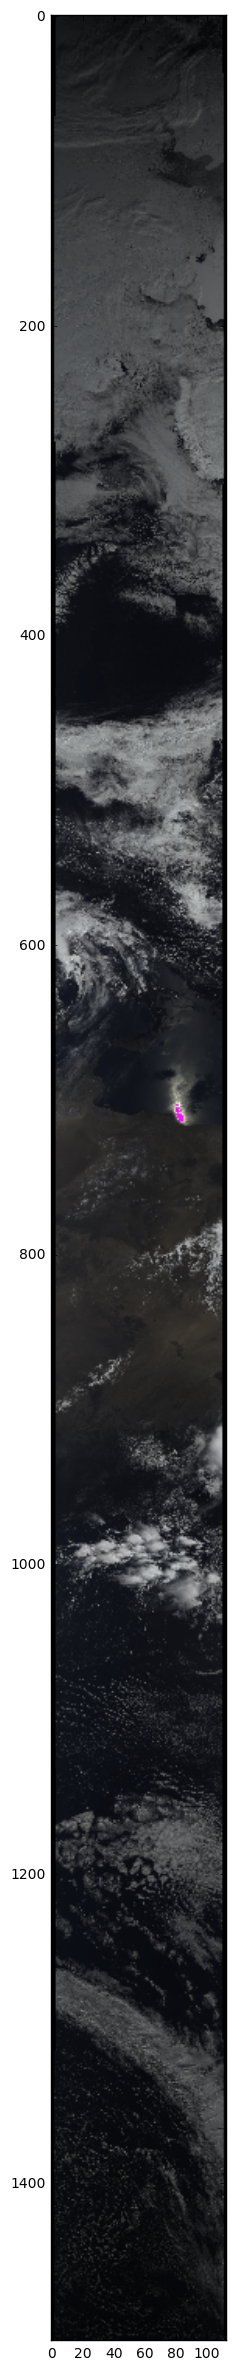

In [6]:
pl.figure(figsize=(14,30))
pl.subplot(1,2,1)
rgb=np.dstack((rad['norm_radiance_4'],rad['norm_radiance_3'],rad['norm_radiance_2']))
rgb.shape
#pl.imshow(rgb[4000//stride[0]:6000//stride[0],:,:]/rgb[:,:,2].max())
pl.imshow(rgb/rgb[:,:,2].max())
#pl.colorbar()
#pl.subplot(1,2,2)
#pl.imshow(rad['alb10'][500:900,:])
#pl.imshow(tie['prs'][4000:5000,:].clip(0,1013))

In [7]:
nnn=rad['norm_radiance_10'].size
sha=rad['norm_radiance_10'].shape
oe_ctp=np.zeros(sha)*np.nan
oe_cot=np.zeros(sha)*np.nan
oe_cnv=np.zeros(sha).astype(np.bool)
oe_avk=np.zeros(sha)+1.
oe_cst=np.zeros(sha)+1.
print time.asctime()
a=time.time()
print nnn
jl=0
jw=0l
print ("hier 4")
for i in range(0,nnn):
    inp={'suz':tie['sun_zenith'].flat[i]
        ,'vie':tie['view_zenith'].flat[i]
        ,'azi':180. - tie['ada'].flat[i]   # momo definition
        ,'prs':tie['prs'].flat[i]    # not yet used!!!!
        ,'dwl':rad['lam11'].flat[i]-cc.cha['11']['cwvl']    # first abs-band
        ,'alb':rad['alb10'].flat[i]    # last win-band
        ,'rtoa':{'10':rad['norm_radiance_10'].flat[i]
                ,'11':rad['norm_radiance_11'].flat[i]}
        }

    erg=cc.estimator(inp)
    oe_ctp.flat[i]=erg['ctp']
    oe_cot.flat[i]=erg['cot']
    oe_cnv.flat[i]=erg['res'].conv        
    oe_avk.flat[i]=erg['res'].a.trace()
    oe_cst.flat[i]=erg['res'].sr[0,0]
    jl+=1
            
    if i % 10000 ==0: print i,
print ''
print time.asctime()

Fri Dec  9 15:02:31 2016
169726
hier 4


../cloud_core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  self.mes[len(self.wb)+ich]=-np.log(data['rtoa'][ch] /  data['rtoa'][self.wb[0]])


0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 
Fri Dec  9 15:03:19 2016


/home/olaf/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


all DONE!!


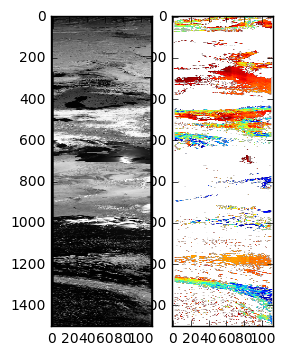

In [8]:
ok= oe_cnv & (oe_cot > 0.8)
#pl.figure(figsize=(32,24))
pl.subplot(1,4,2)
pl.imshow(np.where(ok,oe_ctp,np.nan),aspect='auto')
#pl.imshow(oe_ctp,aspect='auto')
#pl.colorbar()
#pl.subplot(1,4,3)
#pl.imshow(np.where(ok,oe_cot,np.nan),aspect='auto')
#pl.imshow(oe_cot,aspect='auto')
#pl.colorbar()
pl.subplot(1,4,1)
rgb=np.dstack((rad['norm_radiance_4'],rad['norm_radiance_3'],rad['norm_radiance_2']))
rgb.shape
rrr=(rgb)**1.2
rrr=rad['norm_radiance_13']
pl.imshow(1-rrr/rrr.max(),aspect='auto',cmap='Greys')
#pl.subplot(1,4,4)
#pl.imshow(np.where(oe_cot > 0.8,rad['lam11'],np.nan),aspect='auto')
#pl.colorbar()

print ("all DONE!!")

In [9]:
'''
data={
    'lon'  :{'data':tie['lon'].astype(np.float32) ,
             'attributes':  {
                            'long_name':'longitude',
                            'standard_name': 'longitude',
                            'units':'degrees_east'
                            }
            },
    'lat'  :{'data':tie['latitude'].astype(np.float32),
             'attributes':  {
                            'long_name':'latitude',
                            'standard_name': 'latitude',
                            'units':'degrees_north'
                            }
            },
    'ctp':{'data':oe_ctp.astype(np.float32),
             'attributes':  {
                            'long_name':'cloud top pressure',
                            'units':'hPa',
                            }
         },
    'ctp_uncert':{'data':oe_cst.astype(np.float32)**0.5,
             'attributes':  {
                            'long_name':'cloud top pressure uncertainty',
                            'units':'hPa',
                            }
            },
     'cot':{'data':oe_cot.astype(np.float32),
             'attributes':  {
                            'long_name':'log_10 of cloud optical thickness @750 nm',
                            'units':'1',
                            }
            },
     'cnv':{'data':oe_cnv.astype(np.int8),
             'attributes':  {
                            'long_name':'convergence',
                            'units':'1',
                            }
            }
     }       
#from dict2beamncdf import dict2beamncdf as d2n
#ret=d2n(data,'demo_meris_erg.nc')
'''

"\ndata={\n    'lon'  :{'data':tie['lon'].astype(np.float32) ,\n             'attributes':  {\n                            'long_name':'longitude',\n                            'standard_name': 'longitude',\n                            'units':'degrees_east'\n                            }\n            },\n    'lat'  :{'data':tie['latitude'].astype(np.float32),\n             'attributes':  {\n                            'long_name':'latitude',\n                            'standard_name': 'latitude',\n                            'units':'degrees_north'\n                            }\n            },\n    'ctp':{'data':oe_ctp.astype(np.float32),\n             'attributes':  {\n                            'long_name':'cloud top pressure',\n                            'units':'hPa',\n                            }\n         },\n    'ctp_uncert':{'data':oe_cst.astype(np.float32)**0.5,\n             'attributes':  {\n                            'long_name':'cloud top pressure uncertainty',\n  